<a href="https://colab.research.google.com/github/seunghwan1228/GAN/blob/master/Re)srgan_light_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!kaggle datasets download jessicali9530/celeba-dataset

 98% 1.31G/1.33G [00:15<00:00, 39.1MB/s]
100% 1.33G/1.33G [00:16<00:00, 89.1MB/s]


In [3]:
!nohup unzip /content/celeba-dataset.zip -d /content/dataset/ &

nohup: appending output to 'nohup.out'


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

import os

Data Processing

In [5]:
dir_path = '/content/dataset/img_align_celeba/img_align_celeba/'

In [6]:
len(os.listdir(dir_path))

20714

In [7]:
hr_height = 128
hr_width = 128

lr_height = hr_height // 4
lr_width = hr_width // 4

In [8]:
def img_shape_checker(img_path):
  img = tf.keras.preprocessing.image.load_img(img_path)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  return img_array


def img_generator():
  size = 0.5
  total_length = len(os.listdir(dir_path))
  data_select_prop = int(total_length * size)
  for img_path in os.listdir(dir_path)[:data_select_prop]:
    yield img_shape_checker(os.path.join(dir_path, img_path))


def create_low_resolution_image(img, hr_height=128, hr_width=128):
  if len(img.shape) == 4:
    img_height = img.shape[1]
    img_width = img.shape[2]
  else:
    img_height = img.shape[0]
    img_width = img.shape[1]

  img_lr_height = img_height//4
  img_lr_width = img_width//4

  img_lr = tf.image.resize(img, 
                           size=(img_lr_height, img_lr_width), 
                           method = tf.image.ResizeMethod.BICUBIC)
  
  img_hr = tf.image.resize(img, 
                           size = (hr_height, hr_width),
                           method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  return img_hr, img_lr 


def flip_img(hr_img, lr_img):
  flip_seed = tf.random.uniform(shape=(1, ), minval=0., maxval=1.)
  if flip_seed > 0.5:
    hr_img = tf.image.flip_left_right(hr_img)
    lr_img = tf.image.flip_left_right(lr_img)
  return hr_img, lr_img


def resize_img(img):
  return tf.image.resize(img, 
                         size = (hr_height, hr_width),
                         method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  

def img_normalize(img):
  return (img / 127.5) - 1


def img_denormalize(img):
  return (img + 1) * 127.5


def img_simple_normalize(img):
  return img / 255.


def pixel_shuffle(scale):
  return lambda x : tf.nn.depth_to_space(x, scale)

In [9]:
# Datasets size = 202599
# Get only 100000

BUFFER_SIZE = 1000
BATCH_SIZE = 16

dataset = tf.data.Dataset.from_generator(img_generator, 
                                         output_types=tf.int32, 
                                         output_shapes=(218, 178, 3))

dataset = dataset.map(resize_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.map(create_low_resolution_image,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.map(flip_img,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
dataset

<PrefetchDataset shapes: ((16, 128, 128, 3), (16, 32, 32, 3)), types: (tf.int32, tf.float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


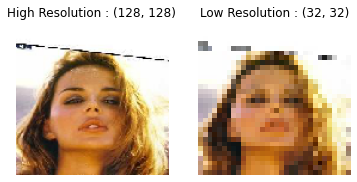

In [11]:
for chk_hr, chk_lr in dataset.take(1):
  chk_hr = chk_hr[0].numpy()
  chk_lr = chk_lr[0].numpy()

  plt.subplot(1, 2, 1)
  plt.imshow(chk_hr)
  plt.title('High Resolution : (128, 128)')
  plt.axis('off')
  
  plt.subplot(1, 2, 2)
  plt.imshow(chk_lr.astype('int'))
  plt.title('Low Resolution : (32, 32)')
  plt.axis('off')

In [12]:
# Generator Block

def residual_block(input_data):
  kernel_init = tf.keras.initializers.random_normal(mean=0.0, stddev=0.02)
  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', kernel_initializer=kernel_init)(input_data)
  x = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=1e-9)(x)
  x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', kernel_initializer=kernel_init)(x)
  x = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=1e-9)(x)
  x = x + input_data
  return x

def upsample_block(input_data):
  kernel_init = tf.keras.initializers.random_normal(mean=0.0, stddev=0.02)
  x = tf.keras.layers.Conv2D(256, 3, 1, padding='same', kernel_initializer=kernel_init)(input_data)
  x = tf.keras.layers.Lambda(pixel_shuffle(2))(x)
  x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
  return x


n_residual_blocks = 6

def sr_generator(input_height, input_width):
  kernel_init = tf.keras.initializers.random_normal(mean=0.0, stddev=0.02)
  input_ = tf.keras.layers.Input(shape = (input_height, input_width, 3))  # 64, 64, 3

  gen_normalize = tf.keras.layers.Lambda(img_simple_normalize)(input_)

  x = tf.keras.layers.Conv2D(64, 9, 1, padding='same', kernel_initializer=kernel_init)(gen_normalize)                            # 64, 64, 64
  x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)                                          # 64, 64, 64

  top_reserve = x

  for _ in range(n_residual_blocks):
    x = residual_block(x)

  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', kernel_initializer=kernel_init)(x)
  x = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=1e-9)(x)
  x = x + top_reserve

  for _ in range(2):
    x = upsample_block(x)
  
  x = tf.keras.layers.Conv2D(3, 9, 1, padding='same', kernel_initializer=kernel_init)(x)

  x = tf.keras.layers.Lambda(img_denormalize)(x)
  model = tf.keras.models.Model(input_, x)
  return model

In [13]:
# Discriminator

def conv_block(input_data, filters, strides):
  kernel_init = tf.keras.initializers.random_normal(mean=0.0, stddev=0.02)
  x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same', kernel_initializer=kernel_init)(input_data)
  x = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=1e-9)(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  return x


def sr_discriminator(hr_height, hr_width):
  kernel_init = tf.keras.initializers.random_normal(mean=0.0, stddev=0.02)
  input_ = tf.keras.layers.Input(shape = (hr_height, hr_width, 3))

  normalize = tf.keras.layers.Lambda(img_normalize)(input_)

  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', kernel_initializer=kernel_init)(normalize)
  x = tf.keras.layers.LeakyReLU(0.2)(x)
  b1 = conv_block(x, 64, 2)
  b2 = conv_block(b1, 128, 1)
  b3 = conv_block(b2, 128, 2)
  b4 = conv_block(b3, 256, 1)
  b5 = conv_block(b4, 256, 2)
  b6 = conv_block(b5, 512, 1)
  b7 = conv_block(b6, 512, 2)

  d1 = tf.keras.layers.Flatten()(b7)
  d1 = tf.keras.layers.Dense(1024, kernel_initializer=kernel_init)(d1)
  d1 = tf.keras.layers.LeakyReLU(0.2)(d1)

  d2 = tf.keras.layers.Dense(1, activation='sigmoid')(d1)

  model = tf.keras.models.Model(input_, d2)  #1,
  return model

In [14]:
def vgg_feature_extraction():
  vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg_selection = vgg_model.layers[:-1]
  vgg_selection_model = tf.keras.Sequential(vgg_selection)
  vgg_selection_model.trainable=False
  return vgg_selection_model  # output : (16, 16, 512)

In [15]:
def get_feature_result(input_, vgg_model):
  preprocessed = tf.keras.applications.vgg19.preprocess_input(input_)
  return vgg_model(preprocessed)

In [16]:
# Content Loss (Pixel-wise MSE)

r = 4

# target = 256, 256, 3
# pred = 256, 256, 3

def compute_content_mse_loss(target, pred, r):
  pixel_mse = tf.losses.mean_squared_error(target, pred)
  return (1/r**2) * pixel_mse

In [17]:
# Compute VGG loss

def compute_content_vgg_loss(target, pred, vgg_model):
  vgg_hr = get_feature_result(target, vgg_model) / 12.75
  vgg_sr = get_feature_result(pred, vgg_model) / 12.75

  vgg_content_loss = tf.keras.losses.mean_squared_error(vgg_hr, vgg_sr)
  return vgg_content_loss

In [18]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def compute_generator_loss(generated_output):
  return loss_object(tf.ones_like(generated_output), generated_output)


def compute_discriminator_loss(hr_output, sr_output):
  hr_loss = loss_object(tf.ones_like(hr_output), hr_output)
  sr_loss = loss_object(tf.zeros_like(sr_output), sr_output)
  return hr_loss + sr_loss

In [19]:
generator = sr_generator(lr_height, lr_width)
discriminator = sr_discriminator(hr_height, hr_width)

vgg_extractor = vgg_feature_extraction()

gen_optimizer = tf.keras.optimizers.Adam(1e-5, epsilon=1e-9)
disc_optimizer = tf.keras.optimizers.Adam(1e-5, epsilon=1e-9)

80142336/80134624 [==============================] - 1s 0us/step


In [20]:
import datetime

log_dir = '/content/logs/'
checkpoint_dir = '/content/ckpt'
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discirminator=discriminator,
                                 gen_optimizer = gen_optimizer,
                                 disc_optimizer = disc_optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5, keep_checkpoint_every_n_hours=1)

summary_writer = tf.summary.create_file_writer(logdir=log_dir + 'fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [21]:
def train_step(hr_data, lr_data):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    sr_image = generator(lr_data)
    
    disc_sr = discriminator(sr_image)
    disc_hr = discriminator(hr_data)

    content_loss = compute_content_vgg_loss(hr_data, sr_image, vgg_extractor)
    gen_loss = compute_generator_loss(disc_sr)   # ∑−logD(G(I_LR)
    total_gen_loss = content_loss + (10**-3) * gen_loss

    disc_loss = compute_discriminator_loss(disc_hr, disc_sr)

  gen_gradient = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
  disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))

In [22]:
import tqdm

def train_srgan(dataset, epochs):
  for epoch in tqdm.tqdm_notebook(range(epochs)):
    for hr_data, lr_data in dataset:
      train_step(hr_data, lr_data)
    
    if (epoch + 1) % 5 == 0:
      ckpt_manager.save()

In [ ]:
train_srgan(dataset, 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
